In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import random
# import torch
# import plotly.express as px
import time
import numpy
from matplotlib.path import Path
from utils import extract_number

In [ ]:
area = [405, 425, 396, 404]
cut = 1694107

In [ ]:
def process_data(file_name, grid=(500, 200)):
    data = np.loadtxt(file_name, skiprows=2, usecols=(0, 1, 2, 3))
    data[:, 0] /= 128
    data[:, 1] /= 128
    data = data[:cut]
    filtered_data = data[(data[:, 0] >= area[0]) & (data[:, 0] <= area[1]) & (data[:, 1] >= area[2]) & (data[:, 1] <= area[3])]
    x, y, u, v = filtered_data.T
    naca_filepath = os.path.join('data', 'n0012.dat')
    with open(naca_filepath, 'r') as infile:
        xx, yy = numpy.loadtxt(infile, dtype=float, unpack=True, skiprows=1)
    xx = xx * 16 + 391.75
    yy = yy * 16 + 400
    naca_path = Path(np.column_stack([xx, yy]))
    for i in range(len(x)):
        if naca_path.contains_point((x[i], y[i])):
            u[i] = 0
            v[i] = 0
    # s = np.sqrt(u**2 + v**2)
    xi = np.linspace(area[0], area[1], grid[0])
    yi = np.linspace(area[2], area[3], grid[1])
    xi, yi = np.meshgrid(xi, yi)
    ui = griddata((x, y), u, (xi, yi), method='linear')
    vi = griddata((x, y), v, (xi, yi), method='linear')
    return (xi, yi, ui, vi)

In [ ]:
def generate_data(dir):
    file_names = [f for f in os.listdir(dir) if f.endswith('.dat')]
    file_names.sort(key=extract_number)
    data_u = []
    data_v = []
    grid = []
    for file_name in file_names[:]:
        z = process_data(os.path.join(dir, file_name))
        data_u.append(z[2])
        data_v.append(z[3])
        grid.append(z[:2])
        print("finished", file_name)
    return (data_u, data_v, grid)

In [ ]:
u,v, _ = generate_data('data/naca_new/')
u = np.array(u)
v = np.array(v)
print(u.shape)
print(v.shape)
np.save('data_u.npy', u)
np.save('data_v.npy', v)

In [ ]:
u = np.load("data_u.npy")
print(u.shape)
plt.figure()
plt.imshow(u[2], origin='lower')

In [21]:
from torch.utils.data import DataLoader
from utils import NACA0012
train_dataset = NACA0012(is_train=True,
                        dir='.',
                        n_frames_input=5,
                        n_frames_output=5)
import torch
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ru shape: (235, 200, 500)
self:  (160, 200, 500)
Loaded 16 samples (train)


0 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
1 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
2 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
3 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
4 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
torch.Size([5, 5, 1, 200, 500]) torch.Size([5, 5, 1, 200, 500]) tensor(0.0680) tensor(0.)


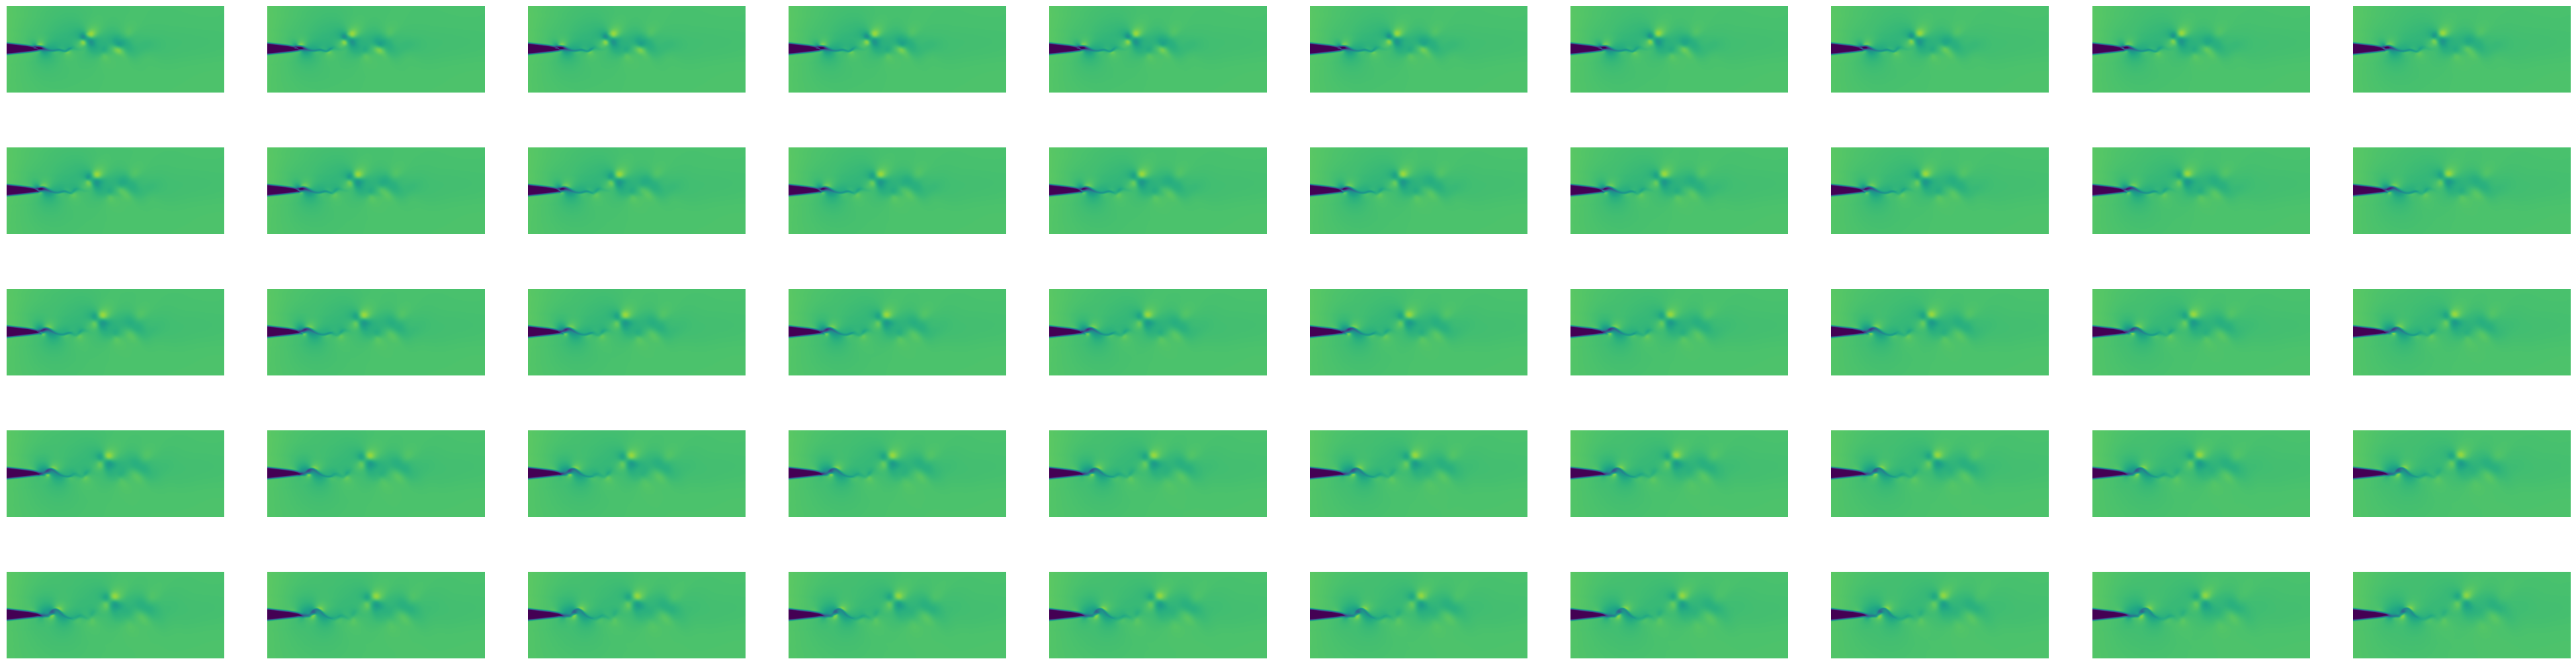

In [23]:
import numpy as np
# choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for batch_idx, (i, targets, inputs) in enumerate(train_loader):
    inputs = inputs.float().to(device)
    targets = targets.float().to(device)
    print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    images = torch.cat([inputs, targets], dim=1)
    _, axarr = plt.subplots(images.shape[0], images.shape[1], figsize=(images.shape[1]*batch_size, images.shape[0]*batch_size))
    plt.subplots_adjust(wspace=0.2, hspace=-0.8)
    for b in range(images.shape[0]):
        for n in range(images.shape[1]):
            plot_img = images[b, n, 0].cpu().numpy()
            axarr[b][n].imshow(plot_img, origin='lower', vmax=0.08, vmin=0)
            axarr[b][n].axis("off")
    break

ru shape: (235, 200, 500)
self:  (74, 200, 500)
Loaded 7 samples (valid)
0 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
1 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
2 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
3 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
4 torch.Size([5, 1, 200, 500]) torch.Size([5, 1, 200, 500])
torch.Size([5, 5, 1, 200, 500]) torch.Size([5, 5, 1, 200, 500]) tensor(0.0762) tensor(0.)


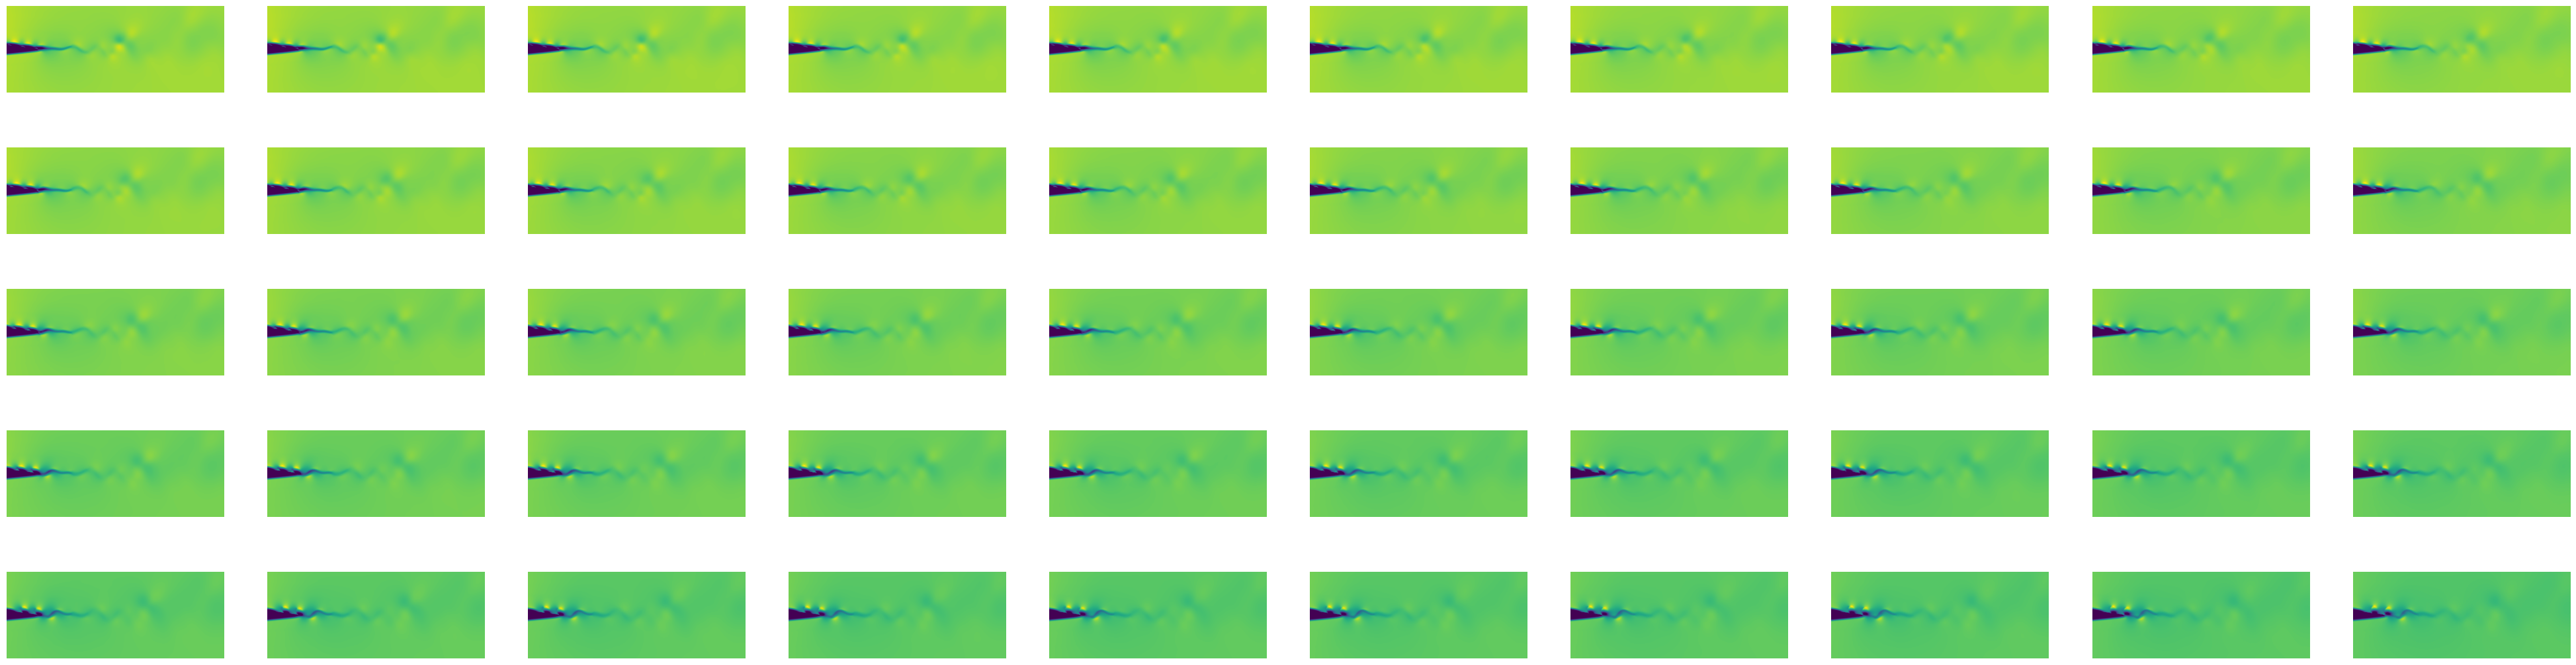

In [19]:
valid_dataset = NACA0012(is_train=False,
                        dir='.',
                        n_frames_input=5,
                        n_frames_output=5)
batch_size = 5
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# plot the first batch of the validation set
for batch_idx, (i, targets, inputs) in enumerate(valid_loader):
    inputs = inputs.float().to(device)
    targets = targets.float().to(device)
    print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    images = torch.cat([inputs, targets], dim=1)
    _, axarr = plt.subplots(images.shape[0], images.shape[1], figsize=(images.shape[1]*batch_size, images.shape[0]*batch_size))
    plt.subplots_adjust(wspace=0.2, hspace=-0.8)
    for b in range(images.shape[0]):
        for n in range(images.shape[1]):
            plot_img = images[b, n, 0].cpu().numpy()
            axarr[b][n].imshow(plot_img, origin='lower')
            axarr[b][n].axis("off")
    break